## Firstly download CIFAR-1O dataset

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [6]:
import os
!ls
os.chdir("drive/Akademik/Ozyegin/CS566/Project 2")
!ls

datalab  drive
06_lasso_and_ridge_regression.ipynb
data
drive
FK.docx
muhammet_oguz_ozcan_cs566_project_2_report.docx
Project2_M_Oguz_Ozcan.ipynb
project2.pdf
__pycache__
tmp_data
TrainModel_SaveToDisk_CS566_M_Oguz_Ozcan.ipynb
~WRL1236.tmp


In [7]:
#The url of the CIFAR-10 data and the path of where to download
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "data/CIFAR-10/"

base_dir = os.getcwd()

print(base_dir)
file_path = 'data/CIFAR-10/'
download_path = os.path.join(base_dir, file_path)
print(download_path)

/content/drive/Akademik/Ozyegin/CS566/Project 2
/content/drive/Akademik/Ozyegin/CS566/Project 2/data/CIFAR-10/


In [0]:
########################################################################
#
# Functions for downloading and extracting data-files from the internet.
#
# Implemented in Python 3.5
#
########################################################################
#
# This file is part of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2016 by Magnus Erik Hvass Pedersen
#
########################################################################

import sys
import os
import urllib.request
import tarfile

########################################################################


def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()


########################################################################


def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        # Unpack the tar-ball.
        tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("unpacking...")
	# Unpack the tar-ball.
        tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)
        print("Data has apparently already been downloaded and unpacked!")


########################################################################

In [9]:
maybe_download_and_extract(url, download_path)  #download_dir

unpacking...
Data has apparently already been downloaded and unpacked!


### Unpickle function for serialized images

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### Function to reshape images from (50000, 3072) to (50000, 32, 32, 3) or (10000, 3072) to (10000, 32, 32, 3)

In [0]:
def prepare_input(data=None, labels=None):
    image_height = 32 
    image_width = 32
    image_depth = 3
    
    assert(data.shape[1] == image_height * image_width * image_depth)
    assert(data.shape[0] == labels.shape[0])
    #do mean normaization across all samples
    mu = np.mean(data, axis=0)
    mu = mu.reshape(1,-1)
    sigma = np.std(data, axis=0)
    sigma = sigma.reshape(1, -1)
    data = data - mu
    data = data / sigma
    is_nan = np.isnan(data)
    is_inf = np.isinf(data)
    if np.any(is_nan) or np.any(is_inf):
        print('data is not well-formed : is_nan {n}, is_inf: {i}'.format(n= np.any(is_nan), i=np.any(is_inf)))
    #data is transformed from (no_of_samples, 3072) to (no_of_samples , image_height, image_width, image_depth)
    #make sure the type of the data is no.float32
    data = data.reshape([-1,image_depth, image_height, image_width])
    data = data.transpose([0, 2, 3, 1])
    data = data.astype(np.float32)
    return data, labels

### Loading data and store them in global arrays, train data, test data and labels for classes

In [0]:
def load_data(data_path=None):
    import os
    from os import walk
    from numpy import array
    
    print("data_path", data_path)
    print("download_path", download_path)
    if data_path is None:
        base_dir = os.getcwd()
        file_path = 'cifar-10-batches-py'
        data_path = os.path.join(download_path, file_path)
        print(data_path)
    
    #Create variables to combine 5 batch training images and their labels
    train_data = []
    train_labels = []

    for (dirpath, dirnames, filenames) in walk(data_path):
        for file in filenames:
            if "data_batch" in file:
                rel_file_path = os.path.join(data_path, file)
                print('Reading file:', rel_file_path)
                d=unpickle(rel_file_path)
                train_data.append(d[b'data'])
                train_labels.append(d[b'labels'])

    #Now concatenate all the data and labels array in one array with size of 50000
    #print(train_labels)
    #print(train_data)
    
    train_data, train_labels = (np.concatenate(train_data).astype(np.float32), np.concatenate(train_labels).astype(np.int32))
    print('Lenght of the train images:', len(train_data))
    print('Lenght of the train labels:', len(train_labels))
    print('Shape of the train images:', train_data.shape)
    print('Shape of the train labels:', train_labels.shape)

    #Now read test data, which is in test_batch file
    #Create variables to hold test data and corresponding labels
    test_data = []
    test_labels = []

    test_rel_file_path = os.path.join(data_path, 'test_batch')
    print('Reading file:', test_rel_file_path)
    d = unpickle(test_rel_file_path)

    #Convert to numpy array to be able to reshape using prepare_input method
    test_data = array(d[b'data'])
    test_labels = array(d[b'labels'])

    print('Lenght of the test images:', len(test_data))
    print('Lenght of the test labels:', len(test_labels))
    print('Shape of the test images:', test_data.shape)
    print('Shape of the test labels:', test_labels.shape)

    #Now let's read label_names which exists in batches.meta file
    label_names_rel_path = os.path.join(data_path, 'batches.meta')
    label_names = unpickle(label_names_rel_path)[b'label_names']

    print('Lenght of the label images:', len(label_names))
    print(label_names)
    
    train_data, train_labels = prepare_input(train_data, train_labels)
    test_data, test_labels = prepare_input(test_data, test_labels)
    print("train_data", train_data.shape)
    print("train_labels", train_labels.shape)
    print("test_data", test_data.shape)
    print("test_labels", test_labels.shape)
    train_labels = (np.arange(10) == train_labels[:, None]).astype(np.float32)
    test_labels = (np.arange(10) == test_labels[:, None]).astype(np.float32)
    print("train_labels", train_labels.shape)
    print("test_labels", test_labels.shape)
    
    #Create global variables to use train, test and label data outside
    global g_train_data, g_test_data, g_label_names, g_train_labels, g_test_labels
    
    g_train_data = train_data
    g_train_labels =  train_labels
    g_test_data = test_data
    g_test_labels = test_labels
    g_label_names = label_names    
    
    return train_data, train_labels, test_data, test_labels, label_names

In [13]:
g_train_data, g_train_labels, g_test_data, g_test_labels, g_label_names = load_data()

data_path None
download_path /content/drive/Akademik/Ozyegin/CS566/Project 2/data/CIFAR-10/
/content/drive/Akademik/Ozyegin/CS566/Project 2/data/CIFAR-10/cifar-10-batches-py
Reading file: /content/drive/Akademik/Ozyegin/CS566/Project 2/data/CIFAR-10/cifar-10-batches-py/data_batch_4
Reading file: /content/drive/Akademik/Ozyegin/CS566/Project 2/data/CIFAR-10/cifar-10-batches-py/data_batch_1
Reading file: /content/drive/Akademik/Ozyegin/CS566/Project 2/data/CIFAR-10/cifar-10-batches-py/data_batch_5
Reading file: /content/drive/Akademik/Ozyegin/CS566/Project 2/data/CIFAR-10/cifar-10-batches-py/data_batch_2
Reading file: /content/drive/Akademik/Ozyegin/CS566/Project 2/data/CIFAR-10/cifar-10-batches-py/data_batch_3
Lenght of the train images: 50000
Lenght of the train labels: 50000
Shape of the train images: (50000, 3072)
Shape of the train labels: (50000,)
Reading file: /content/drive/Akademik/Ozyegin/CS566/Project 2/data/CIFAR-10/cifar-10-batches-py/test_batch
Lenght of the test images: 10

In [0]:
tf.flags.DEFINE_integer("batch_size", 1000, "Batch size during training")

In [45]:
g = tf.Graph()

with g.as_default():   
    X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 32, 32, 3])  #32*32*3  32, 32, 3
    Y = tf.placeholder(name="Y", dtype=tf.float32, shape=[None, 10])

    # define conv-layer variables
    W_conv1 = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], stddev=0.03))    # first conv-layer has 32 kernels, size=5
    b_conv1 = tf.Variable(tf.constant(0.1, shape=[64]))
    W_conv2 = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], stddev=0.03))
    b_conv2 = tf.Variable(tf.constant(0.1, shape=[128]))
    W_conv3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 256], stddev=0.03))
    b_conv3 = tf.Variable(tf.constant(0.1, shape=[256]))  #(?, 16, 16, 64)    
    W_conv4 = tf.Variable(tf.truncated_normal(shape=[3, 3, 256, 512], stddev=0.03))    # first conv-layer has 32 kernels, size=5
    b_conv4 = tf.Variable(tf.constant(0.1, shape=[512]))
    
    
    #First Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv1 = tf.nn.conv2d(X, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1 
    print("h_conv1", h_conv1.shape)
    
    h_relu1 = tf.nn.relu(h_conv1)
    print("h_relu1", h_relu1.shape)
    
    h_pool1 = tf.nn.max_pool(h_relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool1", h_pool1.shape)
    
    #Second Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2
    print("h_conv2", h_conv2.shape)
    
    h_relu2 = tf.nn.relu(h_conv2)
    print("h_relu2", h_relu2.shape)
    
    h_pool2 = tf.nn.max_pool(h_relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool2", h_pool2.shape)    
    
    #Third Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv3 = tf.nn.conv2d(h_pool2, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3
    print("h_conv3", h_conv3.shape)
    
    h_relu3 = tf.nn.relu(h_conv3)
    print("h_relu3", h_relu3.shape)
    
    h_pool3 = tf.nn.max_pool(h_relu3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool1", h_pool3.shape)

    #Fourth Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv4 = tf.nn.conv2d(h_pool3, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + b_conv4
    print("h_conv4", h_conv4.shape)
    
    h_relu4 = tf.nn.relu(h_conv4)
    print("h_relu4", h_relu4.shape)
    
    h_pool4 = tf.nn.max_pool(h_relu4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool4", h_pool4.shape)
    
    # densely/fully connected layer
    W_fc1 = tf.Variable(tf.truncated_normal(shape=[2 * 2 * 512, 1024], stddev=0.1)) 
    b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))

    h_pool2_flat = tf.reshape(h_pool4, [-1, 2*2*512])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # linear classifier
    W_fc2 = tf.Variable(tf.truncated_normal(shape=[1024, 10], stddev=0.1)) 
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) 

    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_conv))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy_loss)
    
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

h_conv1 (?, 32, 32, 64)
h_relu1 (?, 32, 32, 64)
h_pool1 (?, 16, 16, 64)
h_conv2 (?, 16, 16, 128)
h_relu2 (?, 16, 16, 128)
h_pool2 (?, 8, 8, 128)
h_conv3 (?, 8, 8, 256)
h_relu3 (?, 8, 8, 256)
h_pool1 (?, 4, 4, 256)
h_conv4 (?, 4, 4, 512)
h_relu4 (?, 4, 4, 512)
h_pool4 (?, 2, 2, 512)


In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
cfg = tf.ConfigProto(gpu_options=gpu_options)

sess = tf.InteractiveSession(graph=g, config=cfg)
tf.global_variables_initializer().run()

In [0]:
batch_size = 1000
n_classes = 10

# Add ops to save and restore all the variables.
saver = tf.train.Saver()
base_dir = os.getcwd()

number_of_nonzeros_w1 = []
number_of_zeros_w1 = []

#file_path = 'model_no_regression/cnn_model'
#model_path = os.path.join(base_dir, file_path)

#print(model_path)

def all_batches_run_train(n_batches, epoch_count, data=None, labels=None):
    sum_all_batches_loss =0
    sum_all_batches_acc=0
    sum_n_samples=0
    for b in range(n_batches):            
        offset = b * batch_size
        batch_data = data[offset : offset+batch_size, :, :, :]
        n_samples = batch_data.shape[0]
        batch_labels = labels[offset: offset+batch_size, :]
        feed_dict = {X: batch_data, 
                     Y: batch_labels}
        _, loss_value, a, pred, w1 = sess.run([train_step, cross_entropy_loss, accuracy, correct_prediction, W_conv1], feed_dict=feed_dict)         
        
        #Convert w1 to 1d array for simplicity
        w1 = np.reshape(w1, (np.product(w1.shape),))
        n_nonzeros = sum(i > 0.00001 for i in w1)
        n_zeros = len(w1) - n_nonzeros
        #print("Number of non_zeros:", n_nonzeros)
        #print("Number of zeros:", n_zeros)
        
        number_of_nonzeros_w1.append(n_nonzeros)
        number_of_zeros_w1.append(n_zeros)
        
        sum_all_batches_loss += loss_value * n_samples
        sum_all_batches_acc += a * n_samples
        sum_n_samples += n_samples

    #Save model to /models/cnn_model.ckpt
    #save_path = saver.save(sess, 'colab_no_regularization_model') # "/models/cnn_model.ckpt")
    #print("Model saved in path: %s" % save_path)
    return (sum_all_batches_loss/sum_n_samples, sum_all_batches_acc/sum_n_samples, number_of_nonzeros_w1, number_of_zeros_w1)

Epoch 0
2.498682963848114
0.22101999908685685
Epoch 1
1.7914849352836608
0.37440000116825106
Epoch 2
1.594525785446167
0.4438200008869171
Epoch 3
1.4553103423118592
0.49003999888896943
Epoch 4
1.3519368767738342
0.523400000333786
Epoch 5
1.2740502786636352
0.5507799994945526
Epoch 6
1.2127901387214661
0.5732400035858154
Epoch 7
1.1637030482292174
0.5917799985408783
Epoch 8
1.1200257420539856
0.60814000248909
Epoch 9
1.0805153512954713
0.6235799968242646
Epoch 10
1.0446073067188264
0.6369999992847443
Epoch 11
1.0118639886379241
0.6502399957180023
Epoch 12
0.981015853881836
0.6621200013160705
Epoch 13
0.9523709511756897
0.6717800021171569
Epoch 14
0.9250013113021851
0.6815200078487397
Epoch 15
0.8997439157962799
0.6914800024032592
Epoch 16
0.8752198207378388
0.7006199979782104
Epoch 17
0.8525294756889343
0.7091800010204315
Epoch 18
0.8313500201702118
0.7168200027942657
Epoch 19
0.8125647974014282
0.7233599972724915
Epoch 20
0.7957746887207031
0.7294400000572204
Epoch 21
0.784761638641357

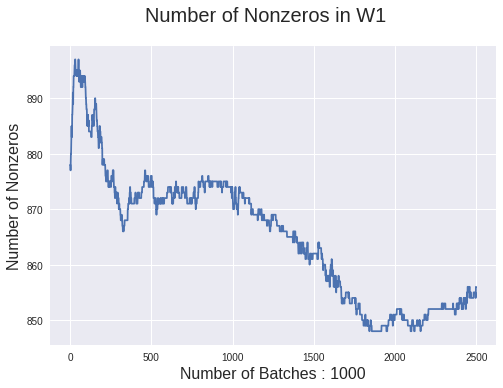

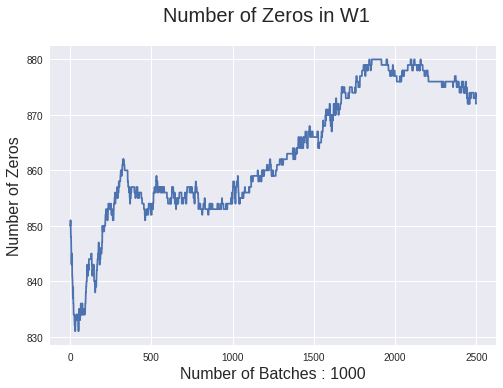

In [48]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

for i in range(50):  #40
    print("Epoch", i)
    mean_loss_per_sample_train, accuracy_per_sample_train, number_of_nonzeros_w1, number_of_zeros_w1 = all_batches_run_train(50, i, g_train_data, g_train_labels) 
    print(mean_loss_per_sample_train)
    print(accuracy_per_sample_train)
    
x_coordinate_non_zeros = [i for i in range(len(number_of_nonzeros_w1))]
fig = plt.figure()
plt.plot(x_coordinate_non_zeros,number_of_nonzeros_w1)
fig.suptitle('Number of Nonzeros in W1', fontsize=20)
plt.xlabel('Number of Batches : 1000', fontsize=16)
plt.ylabel('Number of Nonzeros', fontsize=16)
plt.show()

x_coordinate_zeros = [i for i in range(len(number_of_zeros_w1))]
fig = plt.figure()
plt.plot(x_coordinate_zeros,number_of_zeros_w1)
fig.suptitle('Number of Zeros in W1', fontsize=20)
plt.xlabel('Number of Batches : 1000', fontsize=16)
plt.ylabel('Number of Zeros', fontsize=16)
plt.show()

### Run the network with test data

In [0]:
batch_size = 1000
n_classes = 10

def all_batches_run_train(n_batches, data=None, labels=None):
    sum_all_batches_loss =0
    sum_all_batches_acc=0
    sum_n_samples=0
    for b in range(n_batches):            
        offset = b * batch_size
        batch_data = data[offset : offset+batch_size, :, :, :]
        n_samples = batch_data.shape[0]
        batch_labels = labels[offset: offset+batch_size, :]
        feed_dict = {X: batch_data, Y: batch_labels}
        _, loss_value, a, pred, w1 =sess.run([train_step, cross_entropy_loss, accuracy, correct_prediction, W_conv1], feed_dict=feed_dict)   #[step, loss, acc],

        sum_all_batches_loss += loss_value * n_samples
        sum_all_batches_acc += a * n_samples
        sum_n_samples += n_samples
        if(n_samples != batch_size):
            print('n_samples =%d' % n_samples)
    return (sum_all_batches_loss/sum_n_samples, sum_all_batches_acc/sum_n_samples)


In [50]:
for i in range(1):
    print("Epoch", i)
    mean_loss_per_sample_train, accuracy_per_sample_train = all_batches_run_train(10, g_test_data, g_test_labels)
    print(mean_loss_per_sample_train)
    print(accuracy_per_sample_train)

Epoch 0
0.9291427493095398
0.7012000024318695


In [0]:
sess.close()

## Now train the network with Lasso - L1 Regularization

In [65]:
g = tf.Graph()

with g.as_default():   
    X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 32, 32, 3])  #32*32*3  32, 32, 3
    Y = tf.placeholder(name="Y", dtype=tf.float32, shape=[None, 10])

    # define conv-layer variables
    W_conv1 = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], stddev=0.03))    # first conv-layer has 32 kernels, size=5
    b_conv1 = tf.Variable(tf.constant(0.1, shape=[64]))
    W_conv2 = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], stddev=0.03))
    b_conv2 = tf.Variable(tf.constant(0.1, shape=[128]))
    W_conv3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 256], stddev=0.03))
    b_conv3 = tf.Variable(tf.constant(0.1, shape=[256]))  #(?, 16, 16, 64)    
    W_conv4 = tf.Variable(tf.truncated_normal(shape=[3, 3, 256, 512], stddev=0.03))    # first conv-layer has 32 kernels, size=5
    b_conv4 = tf.Variable(tf.constant(0.1, shape=[512]))
    
    
    #First Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv1 = tf.nn.conv2d(X, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1 
    print("h_conv1", h_conv1.shape)
    
    h_relu1 = tf.nn.relu(h_conv1)
    print("h_relu1", h_relu1.shape)
    
    h_pool1 = tf.nn.max_pool(h_relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool1", h_pool1.shape)
    
    #Second Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2
    print("h_conv2", h_conv2.shape)
    
    h_relu2 = tf.nn.relu(h_conv2)
    print("h_relu2", h_relu2.shape)
    
    h_pool2 = tf.nn.max_pool(h_relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool2", h_pool2.shape)    
    
    #Third Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv3 = tf.nn.conv2d(h_pool2, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3
    print("h_conv3", h_conv3.shape)
    
    h_relu3 = tf.nn.relu(h_conv3)
    print("h_relu3", h_relu3.shape)
    
    h_pool3 = tf.nn.max_pool(h_relu3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool1", h_pool3.shape)

    #Fourth Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv4 = tf.nn.conv2d(h_pool3, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + b_conv4
    print("h_conv4", h_conv4.shape)
    
    h_relu4 = tf.nn.relu(h_conv4)
    print("h_relu4", h_relu4.shape)
    
    h_pool4 = tf.nn.max_pool(h_relu4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool4", h_pool4.shape)
    
    # densely/fully connected layer
    W_fc1 = tf.Variable(tf.truncated_normal(shape=[2 * 2 * 512, 1024], stddev=0.1)) 
    b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))

    h_pool2_flat = tf.reshape(h_pool4, [-1, 2*2*512])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # linear classifier
    W_fc2 = tf.Variable(tf.truncated_normal(shape=[1024, 10], stddev=0.1)) 
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) 

    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
    
    #Get all the weights
    vars = tf.trainable_variables()
    
    #Create L1 regularization
    l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.001, scope=None)
    regularization = tf.contrib.layers.apply_regularization(l1_regularizer, vars)
    
    cross_entropy_loss_l1_regularized = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_conv) + regularization)
    train_step = tf.train.AdamOptimizer().minimize(cross_entropy_loss_l1_regularized)
    
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

h_conv1 (?, 32, 32, 64)
h_relu1 (?, 32, 32, 64)
h_pool1 (?, 16, 16, 64)
h_conv2 (?, 16, 16, 128)
h_relu2 (?, 16, 16, 128)
h_pool2 (?, 8, 8, 128)
h_conv3 (?, 8, 8, 256)
h_relu3 (?, 8, 8, 256)
h_pool1 (?, 4, 4, 256)
h_conv4 (?, 4, 4, 512)
h_relu4 (?, 4, 4, 512)
h_pool4 (?, 2, 2, 512)


In [0]:
sess = tf.InteractiveSession(graph=g)
tf.global_variables_initializer().run()

batch_size = 1000
n_classes = 10

number_of_nonzeros_w1 = []
number_of_zeros_w1 = []

# Add ops to save and restore all the variables.
#saver = tf.train.Saver()
#base_dir = os.getcwd()
#file_path = 'model_lasso/cnn_model_lasso'
#model_path = os.path.join(base_dir, file_path)

def all_batches_run_train(n_batches, data=None, labels=None):
    sum_all_batches_loss =0
    sum_all_batches_acc=0
    sum_n_samples=0
    for b in range(n_batches):            
        offset = b * batch_size
        batch_data = data[offset : offset+batch_size, :, :, :]
        n_samples = batch_data.shape[0]
        batch_labels = labels[offset: offset+batch_size, :]
        feed_dict = {X: batch_data, 
                     Y: batch_labels}
        #_, loss_value, a, w1 =sess.run([step, loss, acc, W1], feed_dict=feed_dict)

        _, loss_value, a, pred, w1 =sess.run([train_step, cross_entropy_loss_l1_regularized, accuracy, correct_prediction, W_conv1], feed_dict=feed_dict)
        
        #Convert w1 to 1d array for simplicity
        w1 = np.reshape(w1, (np.product(w1.shape),))
        n_nonzeros = sum(i > 0.00001 for i in w1)
        n_zeros = len(w1) - n_nonzeros
        #print("Number of non_zeros:", n_nonzeros)
        #print("Number of zeros:", n_zeros)
        #print(w1.shape)
        
        number_of_nonzeros_w1.append(n_nonzeros)
        number_of_zeros_w1.append(n_zeros)
        
        sum_all_batches_loss += loss_value * n_samples
        sum_all_batches_acc += a * n_samples
        sum_n_samples += n_samples
        if(n_samples != batch_size):
            print('n_samples =%d' % n_samples)

    #Save model to /models/cnn_model.ckpt
    #save_path = saver.save(sess, model_path) # "/models/cnn_model.ckpt")
    #print("Model saved in path: %s" % save_path)
    return (sum_all_batches_loss/sum_n_samples, sum_all_batches_acc/sum_n_samples, number_of_nonzeros_w1, number_of_zeros_w1)

Epoch 0
153.514951171875
0.18799999922513963
Epoch 1
90.40207473754883
0.3405199992656708
Epoch 2
51.025146408081056
0.3867400008440018
Epoch 3
29.376498794555665
0.4168800002336502
Epoch 4
18.39858943939209
0.4348799991607666
Epoch 5
12.364363937377929
0.4493000018596649
Epoch 6
8.751832914352416
0.45459999978542326
Epoch 7
6.512365274429321
0.4617599987983704
Epoch 8
5.094941415786743
0.4661999988555908
Epoch 9
4.1867769336700436
0.46966000080108644
Epoch 10
3.6001081609725953
0.4721799975633621
Epoch 11
3.2131599235534667
0.4757399994134903
Epoch 12
2.952702531814575
0.47985999822616576
Epoch 13
2.7721070051193237
0.4824400019645691
Epoch 14
2.645753331184387
0.48554000198841096
Epoch 15
2.552277045249939
0.48883999824523927
Epoch 16
2.481428737640381
0.4914599984884262
Epoch 17
2.425695343017578
0.49317999958992004
Epoch 18
2.3805893087387084
0.49616000056266785
Epoch 19
2.3428318548202514
0.49983999848365784
Epoch 20
2.307655987739563
0.5036800026893615
Epoch 21
2.277091236114502


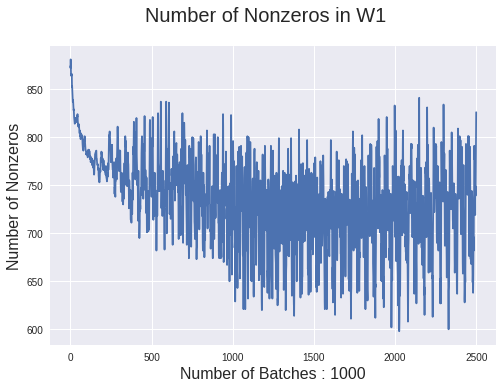

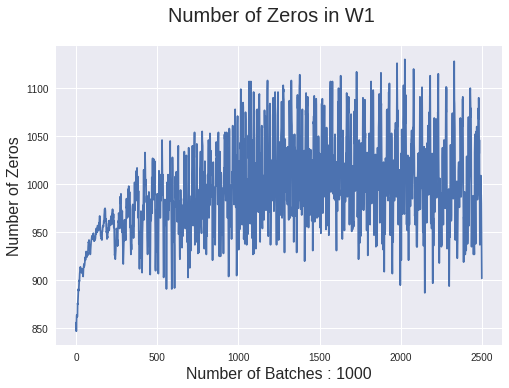

In [67]:
for i in range(50):
    print("Epoch", i)
    mean_loss_per_sample_train, accuracy_per_sample_train, number_of_nonzeros_w1, number_of_zeros_w1 = all_batches_run_train(50, g_train_data, g_train_labels)
    print(mean_loss_per_sample_train)
    print(accuracy_per_sample_train)
    
x_coordinate_non_zeros = [i for i in range(len(number_of_nonzeros_w1))]
fig = plt.figure()
plt.plot(x_coordinate_non_zeros,number_of_nonzeros_w1)
fig.suptitle('Number of Nonzeros in W1', fontsize=20)
plt.xlabel('Number of Batches : 1000', fontsize=16)
plt.ylabel('Number of Nonzeros', fontsize=16)
plt.show()

x_coordinate_zeros = [i for i in range(len(number_of_zeros_w1))]
fig = plt.figure()
plt.plot(x_coordinate_zeros,number_of_zeros_w1)
fig.suptitle('Number of Zeros in W1', fontsize=20)
plt.xlabel('Number of Batches : 1000', fontsize=16)
plt.ylabel('Number of Zeros', fontsize=16)
plt.show()

### Now test L1 Regularization trained network

In [0]:
batch_size = 1000
n_classes = 10

def all_batches_run_train(n_batches, data=None, labels=None):
    sum_all_batches_loss =0
    sum_all_batches_acc=0
    sum_n_samples=0
    for b in range(n_batches):            
        offset = b * batch_size
        batch_data = data[offset : offset+batch_size, :, :, :]
        n_samples = batch_data.shape[0]
        batch_labels = labels[offset: offset+batch_size, :]
        feed_dict = {X: batch_data, Y: batch_labels}
        _, loss_value, a, pred, w1 =sess.run([train_step, cross_entropy_loss_l1_regularized, accuracy, correct_prediction, W_conv1], feed_dict=feed_dict)   #[step, loss, acc],

        sum_all_batches_loss += loss_value * n_samples
        sum_all_batches_acc += a * n_samples
        sum_n_samples += n_samples
        if(n_samples != batch_size):
            print('n_samples =%d' % n_samples)
    return (sum_all_batches_loss/sum_n_samples, sum_all_batches_acc/sum_n_samples)

In [69]:
for i in range(1):
    print("Epoch", i)
    mean_loss_per_sample_train, accuracy_per_sample_train = all_batches_run_train(10, g_test_data, g_test_labels)
    print(mean_loss_per_sample_train)
    print(accuracy_per_sample_train)

Epoch 0
1.9713209509849547
0.5585999965667725


## Now train the network with Ridge - L2 Regularization

In [59]:
g = tf.Graph()

with g.as_default():   
    X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 32, 32, 3])  #32*32*3  32, 32, 3
    Y = tf.placeholder(name="Y", dtype=tf.float32, shape=[None, 10])

    # define conv-layer variables
    W_conv1 = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], stddev=0.03))    # first conv-layer has 32 kernels, size=5
    b_conv1 = tf.Variable(tf.constant(0.1, shape=[64]))
    W_conv2 = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], stddev=0.03))
    b_conv2 = tf.Variable(tf.constant(0.1, shape=[128]))
    W_conv3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 256], stddev=0.03))
    b_conv3 = tf.Variable(tf.constant(0.1, shape=[256]))  #(?, 16, 16, 64)    
    W_conv4 = tf.Variable(tf.truncated_normal(shape=[3, 3, 256, 512], stddev=0.03))    # first conv-layer has 32 kernels, size=5
    b_conv4 = tf.Variable(tf.constant(0.1, shape=[512]))
    
    
    #First Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv1 = tf.nn.conv2d(X, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1 
    print("h_conv1", h_conv1.shape)
    
    h_relu1 = tf.nn.relu(h_conv1)
    print("h_relu1", h_relu1.shape)
    
    h_pool1 = tf.nn.max_pool(h_relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool1", h_pool1.shape)
    
    #Second Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2
    print("h_conv2", h_conv2.shape)
    
    h_relu2 = tf.nn.relu(h_conv2)
    print("h_relu2", h_relu2.shape)
    
    h_pool2 = tf.nn.max_pool(h_relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool2", h_pool2.shape)    
    
    #Third Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv3 = tf.nn.conv2d(h_pool2, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3
    print("h_conv3", h_conv3.shape)
    
    h_relu3 = tf.nn.relu(h_conv3)
    print("h_relu3", h_relu3.shape)
    
    h_pool3 = tf.nn.max_pool(h_relu3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool1", h_pool3.shape)

    #Fourth Conv - Conv - Conv - Relu - MaxPool Layer
    h_conv4 = tf.nn.conv2d(h_pool3, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + b_conv4
    print("h_conv4", h_conv4.shape)
    
    h_relu4 = tf.nn.relu(h_conv4)
    print("h_relu4", h_relu4.shape)
    
    h_pool4 = tf.nn.max_pool(h_relu4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("h_pool4", h_pool4.shape)
    
    # densely/fully connected layer
    W_fc1 = tf.Variable(tf.truncated_normal(shape=[2 * 2 * 512, 1024], stddev=0.1)) 
    b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))

    h_pool2_flat = tf.reshape(h_pool4, [-1, 2*2*512])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # linear classifier
    W_fc2 = tf.Variable(tf.truncated_normal(shape=[1024, 10], stddev=0.1)) 
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) 

    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
    
    #Get all the weights
    vars = tf.trainable_variables()
    
    #Create L1 regularization
    l2_regularizer = tf.contrib.layers.l2_regularizer(scale=0.01, scope=None)
    regularization = tf.contrib.layers.apply_regularization(l2_regularizer, vars)
    
    cross_entropy_loss_l2_regularized = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_conv) + regularization)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy_loss_l2_regularized)
    
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

h_conv1 (?, 32, 32, 64)
h_relu1 (?, 32, 32, 64)
h_pool1 (?, 16, 16, 64)
h_conv2 (?, 16, 16, 128)
h_relu2 (?, 16, 16, 128)
h_pool2 (?, 8, 8, 128)
h_conv3 (?, 8, 8, 256)
h_relu3 (?, 8, 8, 256)
h_pool1 (?, 4, 4, 256)
h_conv4 (?, 4, 4, 512)
h_relu4 (?, 4, 4, 512)
h_pool4 (?, 2, 2, 512)


In [0]:
sess = tf.InteractiveSession(graph=g)
tf.global_variables_initializer().run()

batch_size = 1000
n_classes = 10

number_of_nonzeros_w1 = []
number_of_zeros_w1 = []

# Add ops to save and restore all the variables.
#saver = tf.train.Saver()
#base_dir = os.getcwd()
#file_path = 'model_ridge/cnn_model_ridge'
#model_path = os.path.join(base_dir, file_path)

def all_batches_run_train(n_batches, data=None, labels=None):
    sum_all_batches_loss =0
    sum_all_batches_acc=0
    sum_n_samples=0
    for b in range(n_batches):            
        offset = b * batch_size
        batch_data = data[offset : offset+batch_size, :, :, :]
        n_samples = batch_data.shape[0]
        batch_labels = labels[offset: offset+batch_size, :]
        feed_dict = {X: batch_data, 
                     Y: batch_labels}
        _, loss_value, a, pred, w1 =sess.run([train_step, cross_entropy_loss_l2_regularized, accuracy, correct_prediction, W_conv1], feed_dict=feed_dict)

        #Convert w1 to 1d array for simplicity
        w1 = np.reshape(w1, (np.product(w1.shape),))
        n_nonzeros = sum(i > 0.00001 for i in w1)
        n_zeros = len(w1) - n_nonzeros
        #print("Number of non_zeros:", n_nonzeros)
        #print("Number of zeros:", n_zeros)
        #print(w1.shape)
        
        number_of_nonzeros_w1.append(n_nonzeros)
        number_of_zeros_w1.append(n_zeros)
        
        sum_all_batches_loss += loss_value * n_samples
        sum_all_batches_acc += a * n_samples
        sum_n_samples += n_samples
        if(n_samples != batch_size):
            print('n_samples =%d' % n_samples)

    #Save model to /models/cnn_model.ckpt
    #save_path = saver.save(sess, model_path) # "/models/cnn_model.ckpt")
    #print("Model saved in path: %s" % save_path)
    return (sum_all_batches_loss/sum_n_samples, sum_all_batches_acc/sum_n_samples, number_of_nonzeros_w1, number_of_zeros_w1)

Epoch 0
86.60761688232422
0.2456800000369549
Epoch 1
80.750341796875
0.395780001282692
Epoch 2
75.30102233886718
0.456000000834465
Epoch 3
70.24544967651367
0.4935400015115738
Epoch 4
65.58632743835449
0.5250999981164932
Epoch 5
61.28651252746582
0.5513000005483627
Epoch 6
57.314581604003905
0.5677999985218048
Epoch 7
53.641422805786135
0.5807000017166137
Epoch 8
50.24393096923828
0.5928600001335144
Epoch 9
47.094445343017576
0.604139997959137
Epoch 10
44.17085357666016
0.613160002231598
Epoch 11
41.454241256713864
0.6218399977684022
Epoch 12
38.926685180664066
0.6316000008583069
Epoch 13
36.57512275695801
0.6385199999809266
Epoch 14
34.386581573486325
0.645220000743866
Epoch 15
32.349776916503906
0.6512400007247925
Epoch 16
30.453757209777834
0.657039999961853
Epoch 17
28.688632774353028
0.6625000011920928
Epoch 18
27.045673065185547
0.6684000015258789
Epoch 19
25.516072425842285
0.6739799964427948
Epoch 20
24.09151138305664
0.6787599980831146
Epoch 21
22.76384220123291
0.683500000238

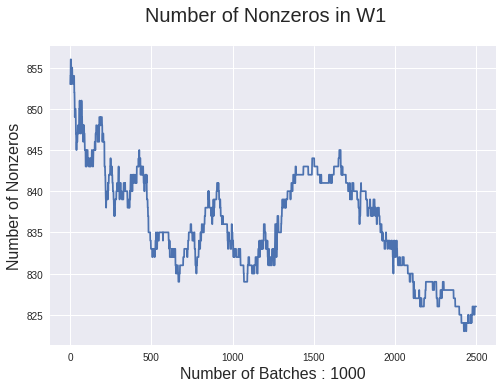

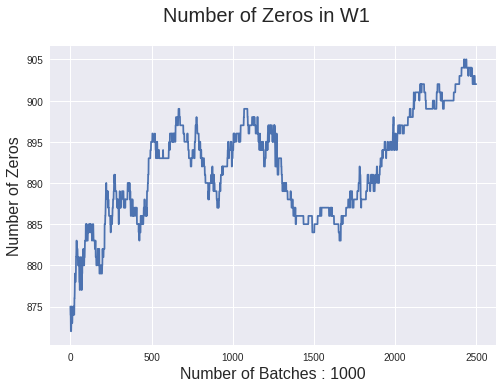

In [62]:
for i in range(50):
    print("Epoch", i)
    mean_loss_per_sample_train, accuracy_per_sample_train, number_of_nonzeros_w1, number_of_zeros_w1 = all_batches_run_train(50, g_train_data, g_train_labels)
    print(mean_loss_per_sample_train)
    print(accuracy_per_sample_train)
    
x_coordinate_non_zeros = [i for i in range(len(number_of_nonzeros_w1))]
fig = plt.figure()
plt.plot(x_coordinate_non_zeros,number_of_nonzeros_w1)
fig.suptitle('Number of Nonzeros in W1', fontsize=20)
plt.xlabel('Number of Batches : 1000', fontsize=16)
plt.ylabel('Number of Nonzeros', fontsize=16)
plt.show()

x_coordinate_zeros = [i for i in range(len(number_of_zeros_w1))]
fig = plt.figure()
plt.plot(x_coordinate_zeros,number_of_zeros_w1)
fig.suptitle('Number of Zeros in W1', fontsize=20)
plt.xlabel('Number of Batches : 1000', fontsize=16)
plt.ylabel('Number of Zeros', fontsize=16)
plt.show()

### Now test L2 Regularization trained network

In [0]:
batch_size = 1000
n_classes = 10

def all_batches_run_train(n_batches, data=None, labels=None):
    sum_all_batches_loss =0
    sum_all_batches_acc=0
    sum_n_samples=0
    for b in range(n_batches):            
        offset = b * batch_size
        batch_data = data[offset : offset+batch_size, :, :, :]
        n_samples = batch_data.shape[0]
        batch_labels = labels[offset: offset+batch_size, :]
        feed_dict = {X: batch_data, Y: batch_labels}
        _, loss_value, a, pred, w1 =sess.run([train_step, cross_entropy_loss_l2_regularized, accuracy, correct_prediction, W_conv1], feed_dict=feed_dict)   #[step, loss, acc],

        sum_all_batches_loss += loss_value * n_samples
        sum_all_batches_acc += a * n_samples
        sum_n_samples += n_samples
        if(n_samples != batch_size):
            print('n_samples =%d' % n_samples)
    return (sum_all_batches_loss/sum_n_samples, sum_all_batches_acc/sum_n_samples)

In [64]:
for i in range(1):
    print("Epoch", i)
    mean_loss_per_sample_train, accuracy_per_sample_train = all_batches_run_train(10, g_test_data, g_test_labels)
    print(mean_loss_per_sample_train)
    print(accuracy_per_sample_train)

Epoch 0
6.76600341796875
0.6888999938964844
